## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102556

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 3579, 'position': 46140, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(1.4305115e-06, dtype=float32)
Coordinates:
    species_id  int64 102556
Frozen(SortedKeysDict({'strain': 200, 'sample': 3579, 'position': 46140, 'allele': 2}))


In [6]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 166, 'position': 46140})

(array([ 7305., 12651.,  8355.,  4943.,  3061.,  2770.,  2314.,  2141.,
         1964.,   636.]),
 array([0.01204819, 0.06506024, 0.11807229, 0.17108434, 0.22409639,
        0.27710843, 0.33012048, 0.38313253, 0.43614458, 0.48915663,
        0.54216867]),
 <BarContainer object of 10 artists>)

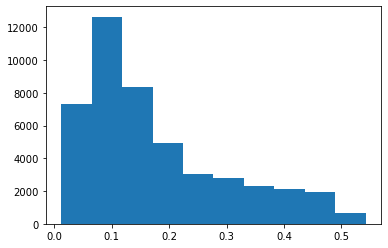

In [7]:
plt.hist(ref.mean('strain'))

In [8]:
# TODO: Decide if I want to discretize here.
ref_dist = ref.discretized().pdist()
fit_dist = fit_genotypes.discretized().pdist()

In [9]:
dedup_thresh = 0.05

ref_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(ref_dist),
    index=ref_dist.columns,
)
fit_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_dist.columns.astype(int),
)

ref_clust.value_counts()

0      6
30     4
1      4
4      3
21     3
      ..
52     1
51     1
50     1
49     1
134    1
Length: 135, dtype: int64

In [10]:
fit_clust.value_counts().sort_values(ascending=False).head()

0     1
11    1
23    1
2     1
3     1
dtype: int64

In [11]:
ref_dedup = sf.Genotypes(ref.to_series().unstack('strain').groupby(ref_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())
fit_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [12]:
(ref.sizes['strain'], ref_dedup.sizes['strain']), (fit_genotypes.sizes['strain'], fit_dedup.sizes['strain'])

((166, 135), (200, 200))

In [13]:
from scipy.spatial.distance import pdist, squareform

g = sf.data.Genotypes.concat(dict(
    ref=ref_dedup,
    fit=fit_dedup,
), dim='strain')

dist = pd.DataFrame(g.discretized().pdist(), index=g.strain, columns=g.strain)

In [14]:
clust_thresh = 0.15

all_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=clust_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(dist),
    index=g.strain,
)

clust_type = all_clust.index.to_series().str[:3]

In [15]:
from itertools import product
    
def count_clust_types(clust, key):
    clust_types = (
        clust
        .to_frame(name='clust')
        .assign(key=key)
        .groupby(['clust', 'key'])
        .apply(len)
        .unstack(fill_value=0)
    )
    all_keys = clust_types.columns.to_list()
    all_possible_clust_types = pd.DataFrame(product([True, False], repeat=len(all_keys)), columns=all_keys)
    return clust_types, clust_types.apply(lambda x: x > 0).groupby(all_keys).apply(len).reindex(all_possible_clust_types, fill_value=0)

clust_stats, clust_type_tally = count_clust_types(all_clust, clust_type)

clust_type_tally

fit    ref  
True   True      56
       False    114
False  True      58
       False      0
dtype: int64

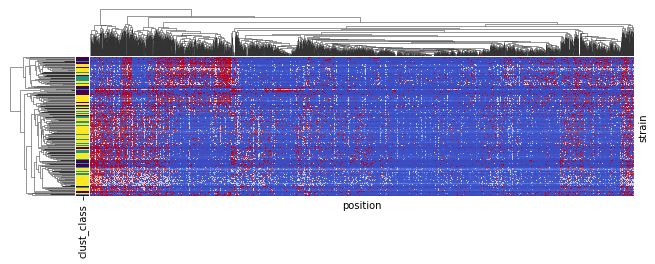

In [16]:
_clust_stats = (
    clust_stats
    .assign(
        tally=lambda x: x.sum(1),
    )
    .assign(only_fit=lambda x: x.ref==0, only_ref=lambda x: x.fit==0)
    .assign(both=lambda x: ~(x.only_fit | x.only_ref))
    .assign(clust_class=lambda x: x[['only_ref', 'both', 'only_fit']].values.argmax(1))
)

clust_genotypes = sf.Genotypes(g.to_series().unstack('strain').groupby(all_clust, axis='columns').mean().rename_axis(columns='strain').T.stack().to_xarray())

sf.plot.plot_genotype(
    clust_genotypes.random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

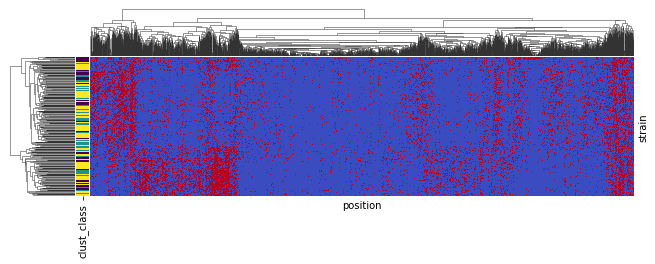

In [17]:
sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=2500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    scaley=1e-2,
    scalex=3e-3,
    yticklabels=0
)

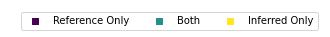

In [18]:
fig, ax = plt.subplots(figsize=(5, 0.5))

for label, c in zip(['Reference Only', 'Both', 'Inferred Only'], mpl.cm.viridis([0, 0.5, 1.0])):
    ax.scatter([], [], marker='s', label=label, c=[c])
ax.legend(ncol=3)
ax.axis('off')

fig.tight_layout()

fig.savefig('fig/cocluster_legend.png', dpi=400, bbox_inches=0, pad_inches='tight')

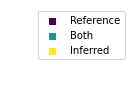

In [19]:
fig, ax = plt.subplots(figsize=(2, 1.5))

for label, c in zip(['Reference', 'Both', 'Inferred'], mpl.cm.viridis([0, 0.5, 1.0])):
    ax.scatter([], [], marker='s', label=label, c=[c])
ax.legend()
ax.axis('off')

fig.tight_layout()

fig.savefig('fig/cocluster_legend_vertical.png', dpi=400, bbox_inches=0, pad_inches='tight')

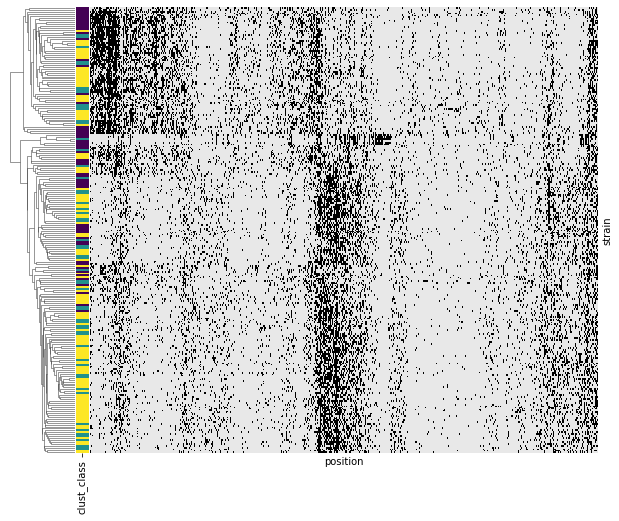

In [37]:
np.random.seed(0)

sf.plot.plot_genotype(
    clust_genotypes.discretized().random_sample(position=3500),
    row_colors_func=lambda w: _clust_stats[['clust_class']].to_xarray(),
    row_linkage_func=lambda w: clust_genotypes.linkage(method='complete'),
    scaley=3e-2,
    scalex=2e-3,
    yticklabels=0,
    dheight=0.001,
    cmap='gray_r',
    norm=mpl.colors.PowerNorm(1, vmin=-0.1, vmax=1.),
)

plt.savefig(f'fig/coclustering_{species_id}.png', dpi=400)

In [21]:
len(_clust_stats)

228

In [22]:
# Count the number of each type of genotype in each type of cluster.
_clust_stats.groupby(['only_fit', 'both', 'only_ref'])[['fit', 'ref']].sum().apply(lambda x: x / x.sum())

key                        fit       ref
only_fit both  only_ref                 
False    False True      0.000  0.444444
         True  False     0.395  0.555556
True     False False     0.605  0.000000

In [23]:
np.random.seed(0)

def permutation_clust_types(clust, key, n=1, progress=False):
    _, observed = count_clust_types(clust, key)
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        permutations.append(count_clust_types(perm_clust, key)[1])
    return observed, pd.DataFrame(permutations)

obs, perm = permutation_clust_types(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [01:24<00:00, 118.25it/s]


In [24]:
obs.to_frame(name='tally').assign(frac=lambda x: x / x.sum())

tally      frac
fit   ref                   
True  True      56  0.245614
      False    114  0.500000
False True      58  0.254386
      False      0  0.000000

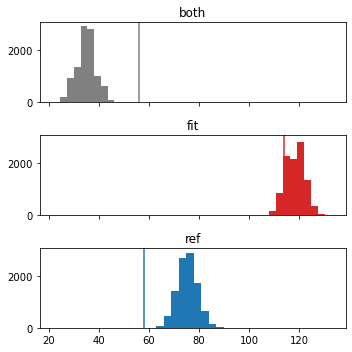

In [25]:
fig, axs = plt.subplots(3, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip([((True, True), 'grey', 'both'), ((True, False), 'tab:red', 'fit'), ((False, True), 'tab:blue', 'ref')], axs):
    ax.hist(perm[key], color=c)
    ax.axvline(obs[key], color=c, label=label)
    ax.set_title(label)
fig.tight_layout()

In [26]:
def tally_permutation_test(obs, perm):    
    out = {}
    for key in obs.index:
        out[key, '>'] = ((obs[key] > perm[key]).sum())
        out[key, '=='] = ((obs[key] == perm[key]).sum())
        out[key, '<'] = ((obs[key] < perm[key]).sum())
    return pd.Series(out).unstack()

tally_permutation_test(obs, perm).apply(lambda x: x / x.sum(), axis=1)

,<,==,>
"(False, False)",0.000000,1.000000,0.00000
"(False, True)",1.000000,0.000000,0.00000
"(True, False)",0.837884,0.060106,0.10201
"(True, True)",0.000000,0.000000,1.00000


In [27]:
np.random.seed(0)

def permutation_strain_clust_type(clust, key, n=1, progress=False):
    clust_stats, _ = count_clust_types(clust, key)
    observed = clust_stats.groupby((clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack()
    permutations = []
    for _ in tqdm(range(n), disable=(not progress)):
        perm_clust = pd.Series(np.random.choice(clust.values, size=len(clust), replace=False), index=clust.index)
        perm_clust_stats, _ = count_clust_types(perm_clust, key)
        permutations.append(perm_clust_stats.groupby((perm_clust_stats > 0).apply(lambda x: tuple(x), axis=1)).sum().stack())
    return observed, pd.DataFrame(permutations)

obs2, perm2 = permutation_strain_clust_type(all_clust, all_clust.index.to_series().str[:3], n=9999, progress=True)

100%|██████████| 9999/9999 [02:13<00:00, 74.91it/s]


In [28]:
obs2

               key
(False, True)  fit      0
               ref     60
(True, False)  fit    121
               ref      0
(True, True)   fit     79
               ref     75
dtype: int64

In [29]:
perm2

(False, True)     (True, False)     (True, True)    
key            fit ref           fit ref          fit ref
0                0  87           143   0           57  48
1                0  86           138   0           62  49
2                0  83           151   0           49  52
3                0  80           141   0           59  55
4                0  84           134   0           66  51
...            ...  ..           ...  ..          ...  ..
9994             0  83           141   0           59  52
9995             0  84           142   0           58  51
9996             0  89           139   0           61  46
9997             0  83           143   0           57  52
9998             0  88           148   0           52  47

[9999 rows x 6 columns]

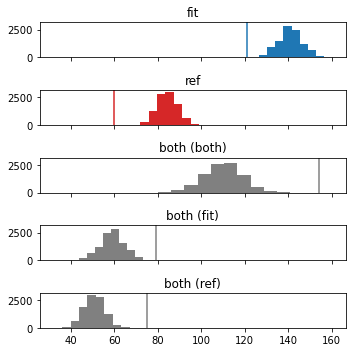

In [30]:
fig, axs = plt.subplots(5, figsize=(5, 5), sharex=True, sharey=True)

for (key, c, label), ax in zip(
    [
        (((True, False), 'fit'), 'tab:blue', 'fit'),
        (((False, True), 'ref'), 'tab:red', 'ref'),
    ],
    axs
):
    ax.hist(perm2[key], color=c)
    ax.axvline(obs2[key], color=c, label=label)
    ax.set_title(label)
    
    

ax = axs[2]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')], c=c)
ax.set_title('both (both)')

ax = axs[3]
c = 'grey'
ax.hist(perm2[((True, True), 'fit')], color=c)
ax.axvline(obs2[((True, True), 'fit')], c=c)
ax.set_title('both (fit)')

ax = axs[4]
c = 'grey'
ax.hist(perm2[((True, True), 'ref')], color=c)
ax.axvline(obs2[((True, True), 'ref')], c=c)
ax.set_title('both (ref)')

fig.tight_layout()

In [33]:
(
    (perm2[((True, True), 'fit')] + perm2[((True, True), 'ref')])
    >=
    (obs2[((True, True), 'fit')] + obs2[((True, True), 'ref')])
).mean()

0.0

In [34]:
(
    perm2[((True, False), 'fit')]
    >= 
    obs2[((True, False), 'fit')]
).mean()

1.0